In [1]:
# EKF Detailed Visualization - Top 5 Flights
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle, FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import pickle
import warnings
warnings.filterwarnings('ignore')

# Setup paths
repo_root = Path.cwd()
for up in [repo_root, repo_root.parent, repo_root.parent.parent]:
    if (up / "src").exists():
        repo_root = up
        break
sys.path.insert(0, str(repo_root))

# Load saved results
results_path = repo_root / "results" / "ekf_results_top5.pkl"
with open(results_path, 'rb') as f:
    ekf_data = pickle.load(f)

top5_detailed = ekf_data['top5_detailed']
top5_flight_ids = ekf_data['top5_flight_ids']

print("="*60)
print("EKF TRAJECTORY PREDICTION VISUALIZATION")
print("="*60)
print(f"\nLoaded {len(top5_detailed)} best performing flights:")
for idx, (fid, rid) in enumerate(top5_flight_ids):
    key = f"{fid}_{rid}"
    rmse = top5_detailed[key]['rmse']
    print(f"  {idx+1}. Flight {fid}: {rmse[60]:.1f}m @ 60s, {rmse[120]:.1f}m @ 120s")

EKF TRAJECTORY PREDICTION VISUALIZATION

Loaded 5 best performing flights:
  1. Flight 4217: 222.3m @ 60s, 485.0m @ 120s
  2. Flight 5707: 359.5m @ 60s, 1148.2m @ 120s
  3. Flight 5840: 620.8m @ 60s, 1860.7m @ 120s
  4. Flight 6151: 697.1m @ 60s, 1574.7m @ 120s
  5. Flight 5251: 852.6m @ 60s, 2021.8m @ 120s


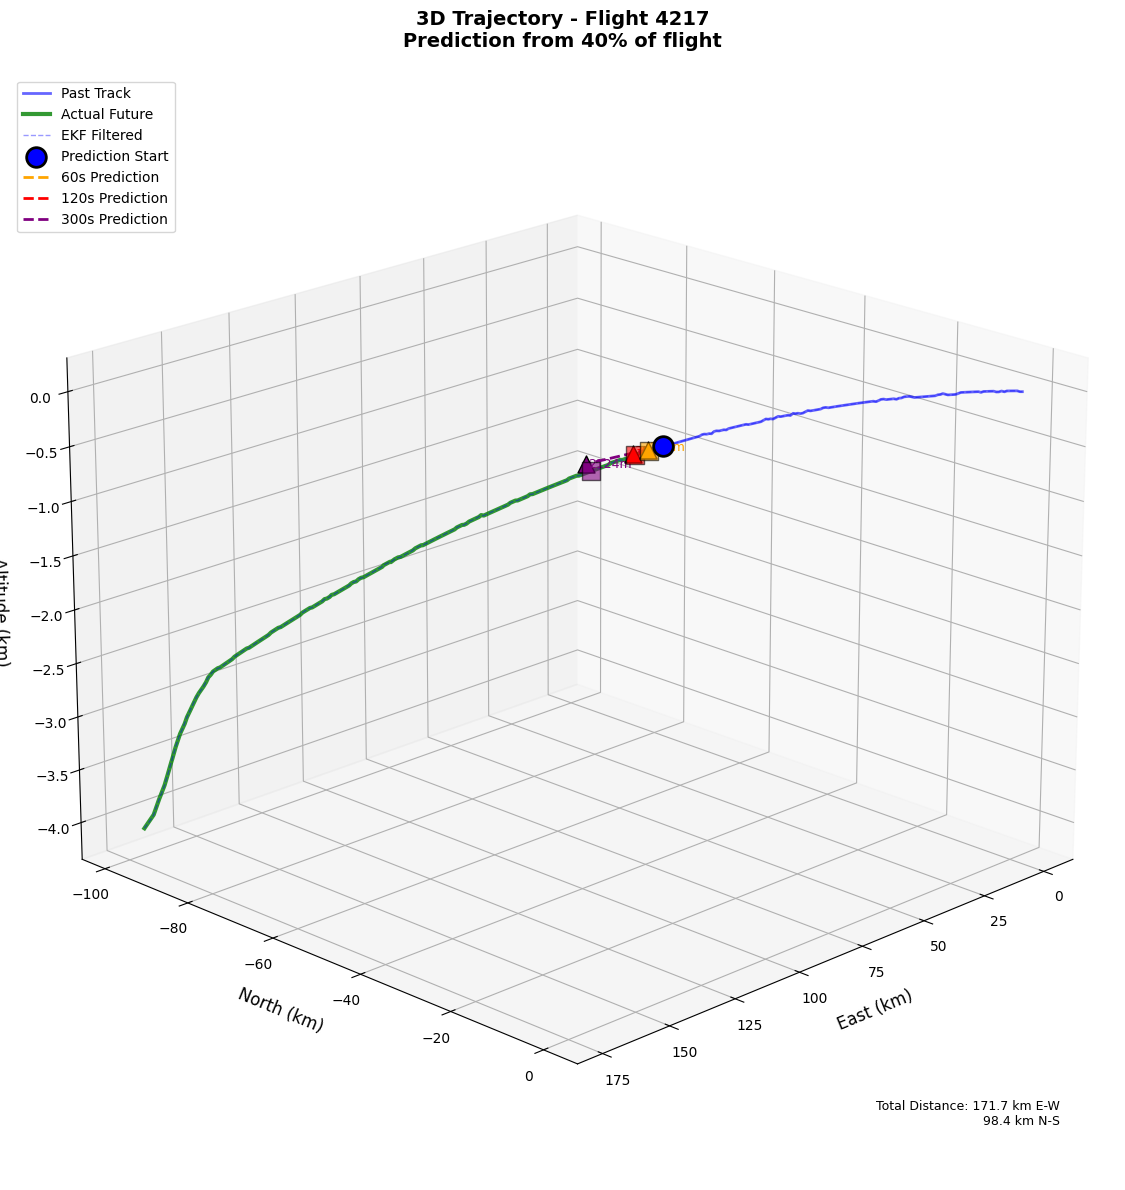

In [3]:
def create_3d_trajectory_plot(flight_data, prediction_point_ratio=0.5):
    """
    Create detailed 3D visualization for a single flight
    Shows: actual path, filtered path, and predictions from a specific point
    """
    
    track = flight_data['resampled_track']
    filtered = flight_data['filtered_track']
    
    # Choose prediction point
    pred_idx = int(len(track) * prediction_point_ratio)
    
    # Get predictions from that point
    from src.ekf_model import CoordinatedTurnEKF, EKFParams
    ekf = CoordinatedTurnEKF(params=EKFParams(), use_wind=False)
    
    # State at prediction point
    state = filtered.iloc[pred_idx]
    x = np.array([state.E_hat, state.N_hat, state.U_hat,
                  state.vE_hat, state.vN_hat, state.vU_hat, state.omega_hat])
    
    # Make predictions
    horizons = [60, 120, 300]
    predictions = {}
    for h in horizons:
        x_pred = ekf.forecast_state(x, h)
        predictions[h] = x_pred[:3]  # E, N, U
    
    # Find actual positions at horizons
    t_start = track.iloc[pred_idx]['time']
    actual_at_horizons = {}
    for h in horizons:
        target_time = t_start + pd.Timedelta(seconds=h)
        future = track[track['time'] >= target_time]
        if len(future) > 0:
            actual_at_horizons[h] = future.iloc[0][['E', 'N', 'U']].values
    
    # Create figure
    fig = plt.figure(figsize=(16, 12))
    
    # Main 3D plot
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot past trajectory (before prediction point)
    past = track.iloc[:pred_idx+1]
    ax.plot(past['E']/1000, past['N']/1000, past['U']/1000,
            'b-', linewidth=2, alpha=0.6, label='Past Track')
    
    # Plot future actual trajectory
    future = track.iloc[pred_idx:]
    ax.plot(future['E']/1000, future['N']/1000, future['U']/1000,
            'g-', linewidth=3, alpha=0.8, label='Actual Future')
    
    # Plot filtered track
    ax.plot(filtered['E_hat']/1000, filtered['N_hat']/1000, filtered['U_hat']/1000,
            'b--', linewidth=1, alpha=0.4, label='EKF Filtered')
    
    # Mark prediction start point
    start_pos = track.iloc[pred_idx]
    ax.scatter(start_pos['E']/1000, start_pos['N']/1000, start_pos['U']/1000,
              c='blue', s=200, marker='o', edgecolors='black', linewidth=2,
              label='Prediction Start', zorder=5)
    
    # Plot predictions and errors
    colors = {60: '#FFA500', 120: '#FF0000', 300: '#800080'}
    
    for h in horizons:
        if h in predictions and h in actual_at_horizons:
            pred = predictions[h]
            actual = actual_at_horizons[h]
            
            # Prediction line
            ax.plot([start_pos['E']/1000, pred[0]/1000],
                   [start_pos['N']/1000, pred[1]/1000],
                   [start_pos['U']/1000, pred[2]/1000],
                   color=colors[h], linewidth=2, linestyle='--',
                   label=f'{h}s Prediction')
            
            # Predicted point
            ax.scatter(pred[0]/1000, pred[1]/1000, pred[2]/1000,
                      c=colors[h], s=150, marker='^', edgecolors='black', linewidth=1)
            
            # Actual point
            ax.scatter(actual[0]/1000, actual[1]/1000, actual[2]/1000,
                      c=colors[h], s=150, marker='s', edgecolors='black', 
                      linewidth=1, alpha=0.6)
            
            # Error line
            ax.plot([pred[0]/1000, actual[0]/1000],
                   [pred[1]/1000, actual[1]/1000],
                   [pred[2]/1000, actual[2]/1000],
                   color=colors[h], linewidth=1, linestyle=':',
                   alpha=0.5)
            
            # Error annotation
            error = np.linalg.norm(pred - actual)
            mid_point = (pred + actual) / 2
            ax.text(mid_point[0]/1000, mid_point[1]/1000, mid_point[2]/1000,
                   f'{error:.0f}m', fontsize=9, color=colors[h])
    
    # Formatting
    ax.set_xlabel('East (km)', fontsize=12, labelpad=10)
    ax.set_ylabel('North (km)', fontsize=12, labelpad=10)
    ax.set_zlabel('Altitude (km)', fontsize=12, labelpad=10)
    ax.set_title(f'3D Trajectory - Flight {flight_data["flight_id"]}\n'
                f'Prediction from {prediction_point_ratio:.0%} of flight',
                fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Set viewing angle
    ax.view_init(elev=20, azim=45)
    
    # Add distance scale
    ax.text2D(0.95, 0.05, f'Total Distance: {track["E"].max()/1000 - track["E"].min()/1000:.1f} km E-W\n'
                         f'{track["N"].max()/1000 - track["N"].min()/1000:.1f} km N-S',
             transform=ax.transAxes, fontsize=9, ha='right')
    
    return fig

# Visualize the best flight
best_flight_key = list(top5_detailed.keys())[0]
best_flight = top5_detailed[best_flight_key]

fig = create_3d_trajectory_plot(best_flight, prediction_point_ratio=0.4)
plt.tight_layout()
plt.show()

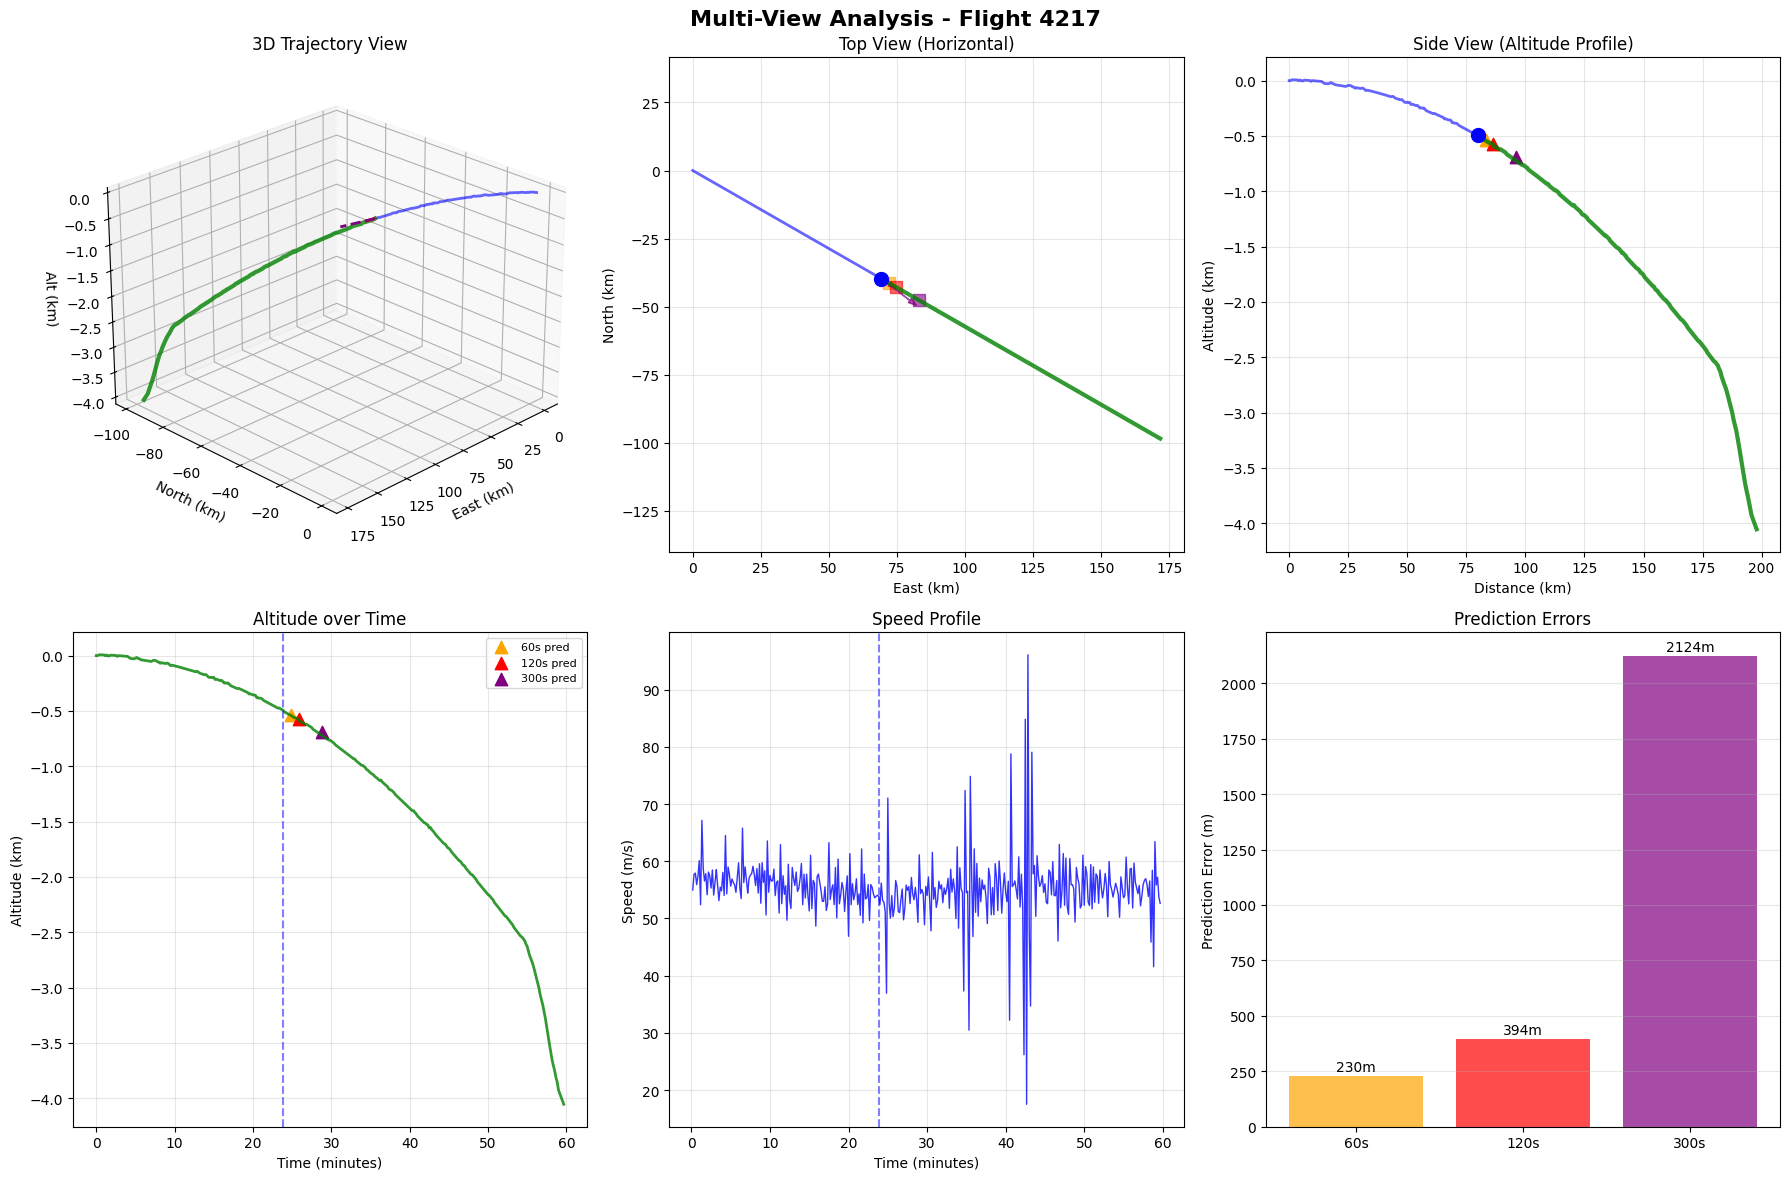

In [5]:
def create_multi_view_visualization(flight_data, pred_point=0.4):
    """Create a comprehensive multi-view visualization"""
    
    track = flight_data['resampled_track']
    filtered = flight_data['filtered_track']
    pred_idx = int(len(track) * pred_point)
    
    # Setup predictions
    from src.ekf_model import CoordinatedTurnEKF, EKFParams
    ekf = CoordinatedTurnEKF(params=EKFParams(), use_wind=False)
    
    state = filtered.iloc[pred_idx]
    x = np.array([state.E_hat, state.N_hat, state.U_hat,
                  state.vE_hat, state.vN_hat, state.vU_hat, state.omega_hat])
    
    horizons = [60, 120, 300]
    predictions = {}
    actual_at_horizons = {}
    errors = {}
    
    t_start = track.iloc[pred_idx]['time']
    for h in horizons:
        predictions[h] = ekf.forecast_state(x, h)[:3]
        target_time = t_start + pd.Timedelta(seconds=h)
        future = track[track['time'] >= target_time]
        if len(future) > 0:
            actual_at_horizons[h] = future.iloc[0][['E', 'N', 'U']].values
            errors[h] = np.linalg.norm(predictions[h] - actual_at_horizons[h])
    
    # Create figure with multiple views
    fig = plt.figure(figsize=(18, 12))
    
    # 3D view
    ax1 = fig.add_subplot(231, projection='3d')
    past = track.iloc[:pred_idx+1]
    future = track.iloc[pred_idx:]
    
    ax1.plot(past['E']/1000, past['N']/1000, past['U']/1000,
            'b-', linewidth=2, alpha=0.6, label='Past')
    ax1.plot(future['E']/1000, future['N']/1000, future['U']/1000,
            'g-', linewidth=3, alpha=0.8, label='Actual Future')
    
    colors = {60: '#FFA500', 120: '#FF0000', 300: '#800080'}
    for h in horizons:
        if h in predictions and h in actual_at_horizons:
            pred = predictions[h]
            ax1.plot([track.iloc[pred_idx]['E']/1000, pred[0]/1000],
                    [track.iloc[pred_idx]['N']/1000, pred[1]/1000],
                    [track.iloc[pred_idx]['U']/1000, pred[2]/1000],
                    color=colors[h], linewidth=2, linestyle='--')
    
    ax1.set_xlabel('East (km)')
    ax1.set_ylabel('North (km)')
    ax1.set_zlabel('Alt (km)')
    ax1.set_title('3D Trajectory View')
    ax1.view_init(elev=25, azim=45)
    
    # Top view (E-N)
    ax2 = fig.add_subplot(232)
    ax2.plot(past['E']/1000, past['N']/1000, 'b-', linewidth=2, alpha=0.6)
    ax2.plot(future['E']/1000, future['N']/1000, 'g-', linewidth=3, alpha=0.8)
    
    start = track.iloc[pred_idx]
    ax2.scatter(start['E']/1000, start['N']/1000, c='blue', s=100, zorder=5)
    
    for h in horizons:
        if h in predictions:
            pred = predictions[h]
            ax2.arrow(start['E']/1000, start['N']/1000,
                     (pred[0]-start['E'])/1000, (pred[1]-start['N'])/1000,
                     head_width=2, head_length=3, fc=colors[h], ec=colors[h], 
                     alpha=0.7, length_includes_head=True)
            
            if h in actual_at_horizons:
                actual = actual_at_horizons[h]
                ax2.scatter(actual[0]/1000, actual[1]/1000, 
                          c=colors[h], s=80, marker='s', alpha=0.6)
    
    ax2.set_xlabel('East (km)')
    ax2.set_ylabel('North (km)')
    ax2.set_title('Top View (Horizontal)')
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')
    
    # Side view (Distance-Altitude)
    ax3 = fig.add_subplot(233)
    
    # Calculate cumulative distance
    dist = np.zeros(len(track))
    for i in range(1, len(track)):
        dist[i] = dist[i-1] + np.sqrt(
            (track.iloc[i]['E'] - track.iloc[i-1]['E'])**2 +
            (track.iloc[i]['N'] - track.iloc[i-1]['N'])**2
        )
    dist = dist / 1000  # Convert to km
    
    ax3.plot(dist[:pred_idx+1], past['U']/1000, 'b-', linewidth=2, alpha=0.6)
    ax3.plot(dist[pred_idx:], future['U']/1000, 'g-', linewidth=3, alpha=0.8)
    ax3.scatter(dist[pred_idx], start['U']/1000, c='blue', s=100, zorder=5)
    
    for h in horizons:
        if h in predictions:
            # Estimate distance for prediction
            pred_dist = dist[pred_idx] + np.sqrt(
                (predictions[h][0] - start['E'])**2 +
                (predictions[h][1] - start['N'])**2
            ) / 1000
            ax3.scatter(pred_dist, predictions[h][2]/1000,
                       c=colors[h], s=80, marker='^')
    
    ax3.set_xlabel('Distance (km)')
    ax3.set_ylabel('Altitude (km)')
    ax3.set_title('Side View (Altitude Profile)')
    ax3.grid(True, alpha=0.3)
    
    # Time series
    ax4 = fig.add_subplot(234)
    time_min = (track['time'] - track['time'].iloc[0]).dt.total_seconds() / 60
    
    ax4.plot(time_min, track['U']/1000, 'g-', linewidth=2, alpha=0.8)
    ax4.axvline(time_min.iloc[pred_idx], color='blue', linestyle='--', alpha=0.5)
    
    for h in horizons:
        pred_time = time_min.iloc[pred_idx] + h/60
        if h in predictions:
            ax4.scatter(pred_time, predictions[h][2]/1000,
                       c=colors[h], s=80, marker='^', label=f'{h}s pred')
    
    ax4.set_xlabel('Time (minutes)')
    ax4.set_ylabel('Altitude (km)')
    ax4.set_title('Altitude over Time')
    ax4.legend(loc='best', fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    # Speed profile
    ax5 = fig.add_subplot(235)
    ax5.plot(time_min, track['speed'], 'b-', linewidth=1, alpha=0.8)
    ax5.axvline(time_min.iloc[pred_idx], color='blue', linestyle='--', alpha=0.5)
    ax5.set_xlabel('Time (minutes)')
    ax5.set_ylabel('Speed (m/s)')
    ax5.set_title('Speed Profile')
    ax5.grid(True, alpha=0.3)
    
    # Error bars
    ax6 = fig.add_subplot(236)
    if errors:
        horizons_with_errors = list(errors.keys())
        error_values = [errors[h] for h in horizons_with_errors]
        colors_list = [colors[h] for h in horizons_with_errors]
        
        bars = ax6.bar(range(len(horizons_with_errors)), error_values,
                      color=colors_list, alpha=0.7)
        ax6.set_xticks(range(len(horizons_with_errors)))
        ax6.set_xticklabels([f'{h}s' for h in horizons_with_errors])
        ax6.set_ylabel('Prediction Error (m)')
        ax6.set_title('Prediction Errors')
        
        for bar, val in zip(bars, error_values):
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                    f'{val:.0f}m', ha='center', va='bottom')
    
    ax6.grid(True, alpha=0.3, axis='y')
    
    fig.suptitle(f'Multi-View Analysis - Flight {flight_data["flight_id"]}',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig

# Create multi-view for best flight
fig = create_multi_view_visualization(best_flight, pred_point=0.4)
plt.show()

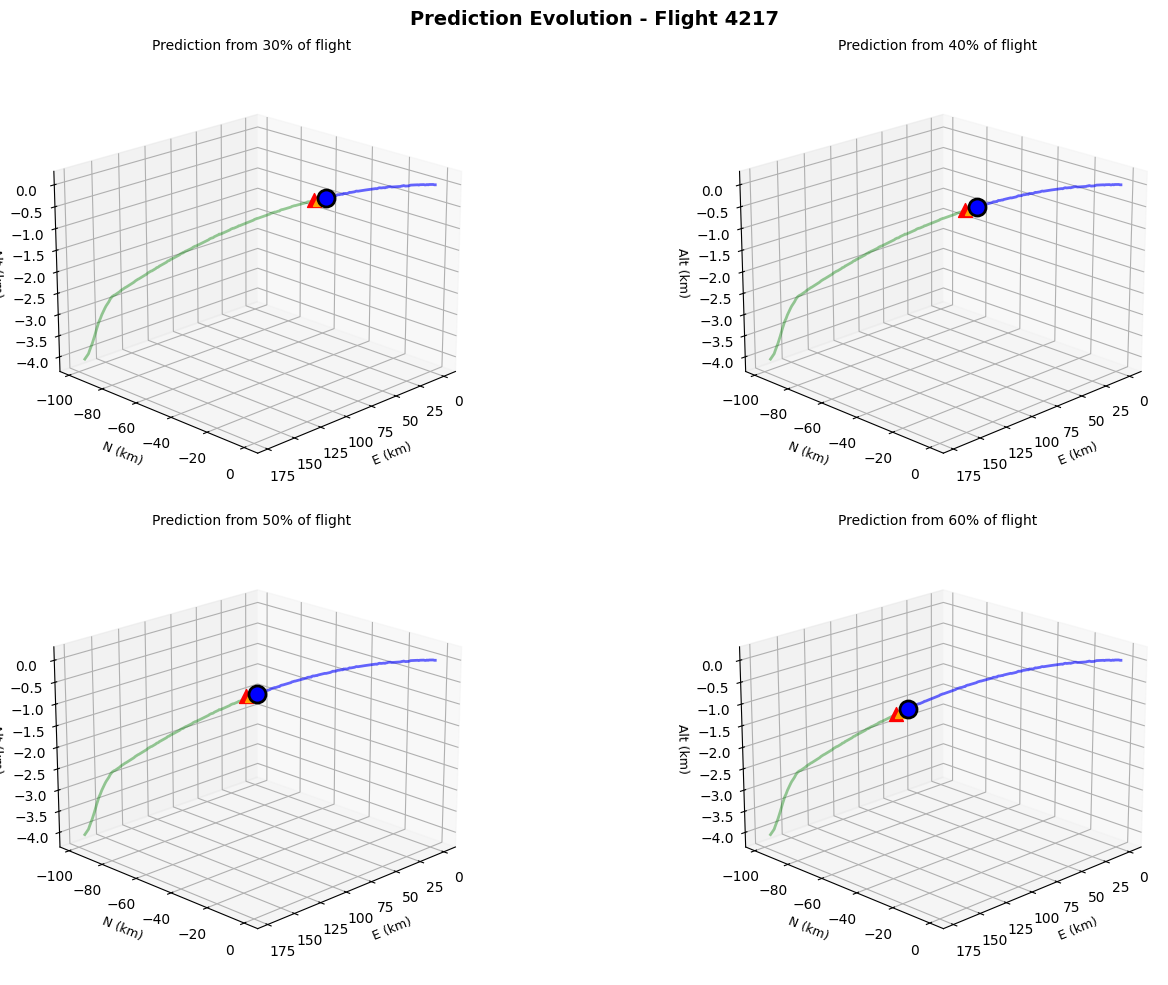

In [6]:
def create_prediction_sequence(flight_data, prediction_points=[0.3, 0.4, 0.5, 0.6]):
    """Show predictions from multiple points along the trajectory"""
    
    from src.ekf_model import CoordinatedTurnEKF, EKFParams
    ekf = CoordinatedTurnEKF(params=EKFParams(), use_wind=False)
    
    track = flight_data['resampled_track']
    filtered = flight_data['filtered_track']
    
    fig = plt.figure(figsize=(16, 10))
    
    for idx, pred_ratio in enumerate(prediction_points):
        ax = fig.add_subplot(2, 2, idx+1, projection='3d')
        
        pred_idx = int(len(track) * pred_ratio)
        
        # Past and future
        past = track.iloc[:pred_idx+1]
        future = track.iloc[pred_idx:]
        
        ax.plot(past['E']/1000, past['N']/1000, past['U']/1000,
               'b-', linewidth=2, alpha=0.6)
        ax.plot(future['E']/1000, future['N']/1000, future['U']/1000,
               'g-', linewidth=2, alpha=0.4)
        
        # Prediction
        state = filtered.iloc[pred_idx]
        x = np.array([state.E_hat, state.N_hat, state.U_hat,
                      state.vE_hat, state.vN_hat, state.vU_hat, state.omega_hat])
        
        # Only show 60s and 120s for clarity
        for h, color in [(60, 'orange'), (120, 'red')]:
            pred = ekf.forecast_state(x, h)[:3]
            
            ax.plot([track.iloc[pred_idx]['E']/1000, pred[0]/1000],
                   [track.iloc[pred_idx]['N']/1000, pred[1]/1000],
                   [track.iloc[pred_idx]['U']/1000, pred[2]/1000],
                   color=color, linewidth=2, linestyle='--', alpha=0.8)
            
            ax.scatter(pred[0]/1000, pred[1]/1000, pred[2]/1000,
                      c=color, s=100, marker='^')
        
        ax.scatter(track.iloc[pred_idx]['E']/1000, 
                  track.iloc[pred_idx]['N']/1000,
                  track.iloc[pred_idx]['U']/1000,
                  c='blue', s=150, marker='o', edgecolors='black', linewidth=2)
        
        ax.set_xlabel('E (km)', fontsize=9)
        ax.set_ylabel('N (km)', fontsize=9)
        ax.set_zlabel('Alt (km)', fontsize=9)
        ax.set_title(f'Prediction from {pred_ratio:.0%} of flight', fontsize=10)
        ax.view_init(elev=20, azim=45)
        ax.grid(True, alpha=0.3)
    
    fig.suptitle(f'Prediction Evolution - Flight {flight_data["flight_id"]}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# Show prediction sequence
fig = create_prediction_sequence(best_flight)
plt.show()

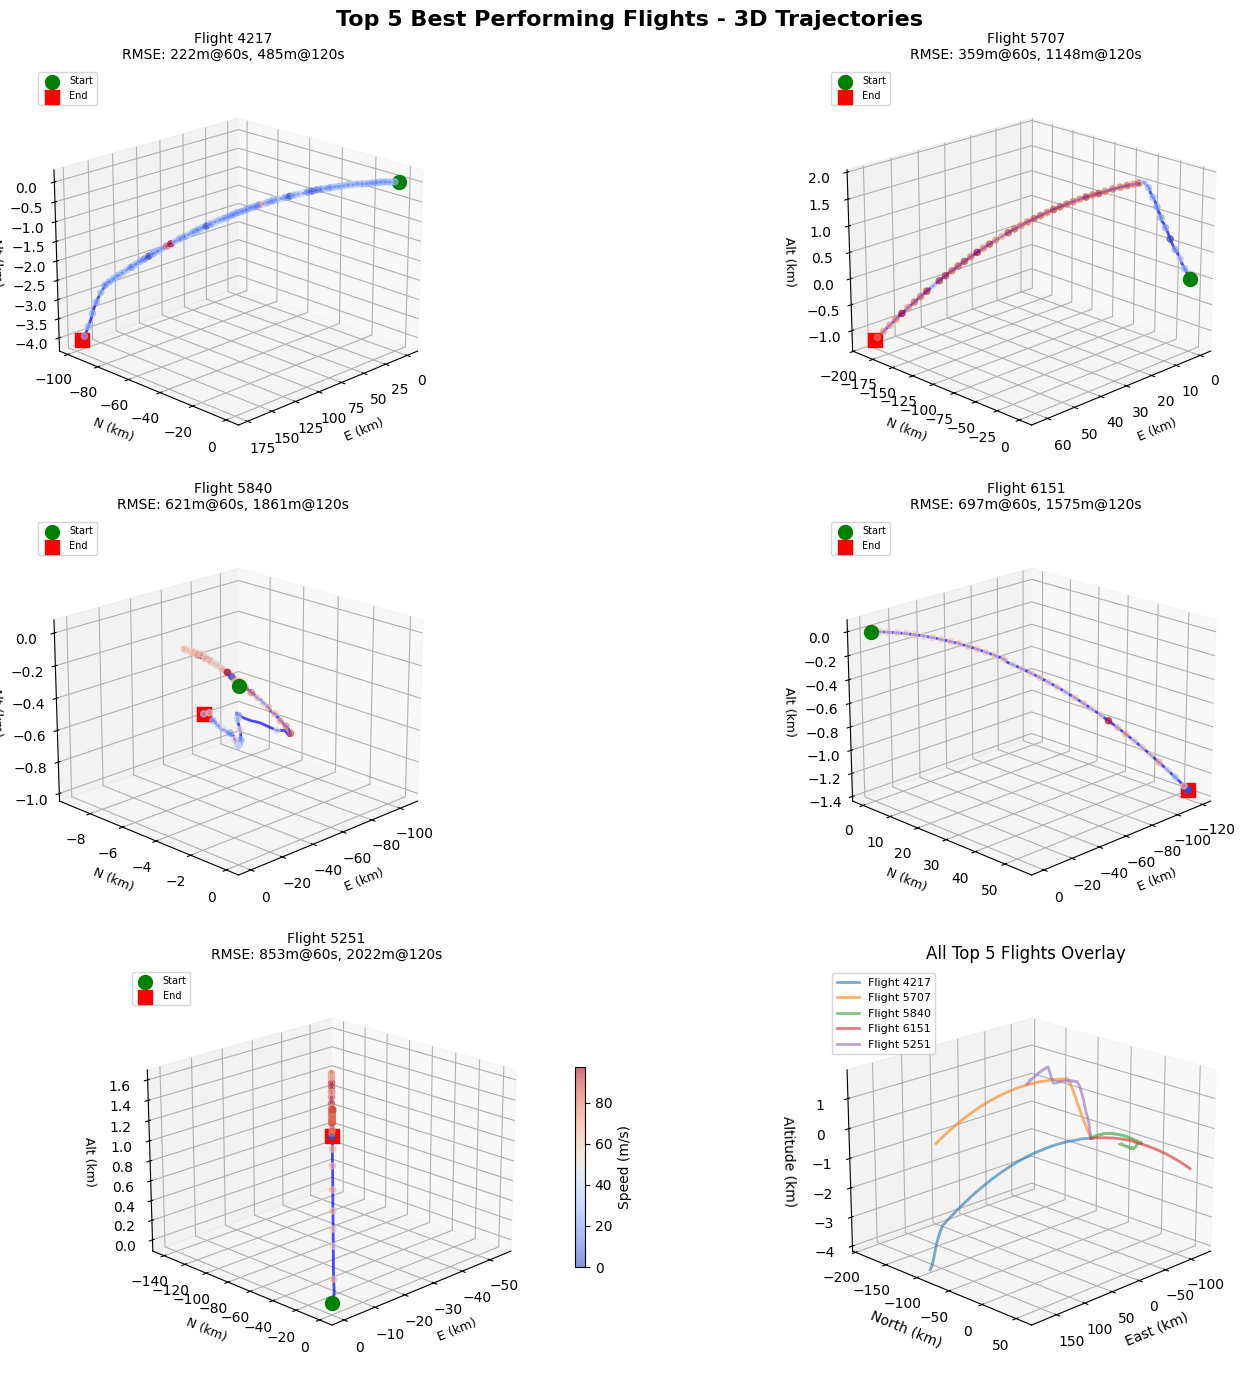

In [7]:
def compare_all_top5_3d():
    """Create a single 3D plot comparing all top 5 flights"""
    
    fig = plt.figure(figsize=(18, 14))
    
    # Individual plots for each flight
    for idx, (flight_key, flight_data) in enumerate(top5_detailed.items()):
        ax = fig.add_subplot(3, 2, idx+1, projection='3d')
        
        track = flight_data['resampled_track']
        
        # Full trajectory
        ax.plot(track['E']/1000, track['N']/1000, track['U']/1000,
               'b-', linewidth=2, alpha=0.7)
        
        # Color by speed
        speed_colors = plt.cm.coolwarm(track['speed'] / track['speed'].max())
        scatter = ax.scatter(track['E'][::10]/1000, track['N'][::10]/1000, 
                           track['U'][::10]/1000,
                           c=track['speed'][::10], cmap='coolwarm', 
                           s=20, alpha=0.6)
        
        # Add start and end markers
        ax.scatter(track['E'].iloc[0]/1000, track['N'].iloc[0]/1000,
                  track['U'].iloc[0]/1000,
                  c='green', s=100, marker='o', label='Start')
        ax.scatter(track['E'].iloc[-1]/1000, track['N'].iloc[-1]/1000,
                  track['U'].iloc[-1]/1000,
                  c='red', s=100, marker='s', label='End')
        
        ax.set_xlabel('E (km)', fontsize=9)
        ax.set_ylabel('N (km)', fontsize=9)
        ax.set_zlabel('Alt (km)', fontsize=9)
        
        rmse = flight_data['rmse']
        ax.set_title(f'Flight {flight_data["flight_id"]}\n'
                    f'RMSE: {rmse[60]:.0f}m@60s, {rmse[120]:.0f}m@120s',
                    fontsize=10)
        ax.view_init(elev=20, azim=45)
        ax.legend(loc='upper left', fontsize=7)
        
        # Add colorbar for the last plot
        if idx == 4:
            plt.colorbar(scatter, ax=ax, label='Speed (m/s)', shrink=0.5)
    
    # Overall comparison in the 6th subplot
    ax_all = fig.add_subplot(3, 2, 6, projection='3d')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for idx, (flight_key, flight_data) in enumerate(top5_detailed.items()):
        track = flight_data['resampled_track']
        ax_all.plot(track['E']/1000, track['N']/1000, track['U']/1000,
                   color=colors[idx], linewidth=2, alpha=0.6,
                   label=f'Flight {flight_data["flight_id"]}')
    
    ax_all.set_xlabel('East (km)')
    ax_all.set_ylabel('North (km)')
    ax_all.set_zlabel('Altitude (km)')
    ax_all.set_title('All Top 5 Flights Overlay')
    ax_all.legend(loc='upper left', fontsize=8)
    ax_all.view_init(elev=20, azim=45)
    
    fig.suptitle('Top 5 Best Performing Flights - 3D Trajectories',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

fig = compare_all_top5_3d()
plt.show()

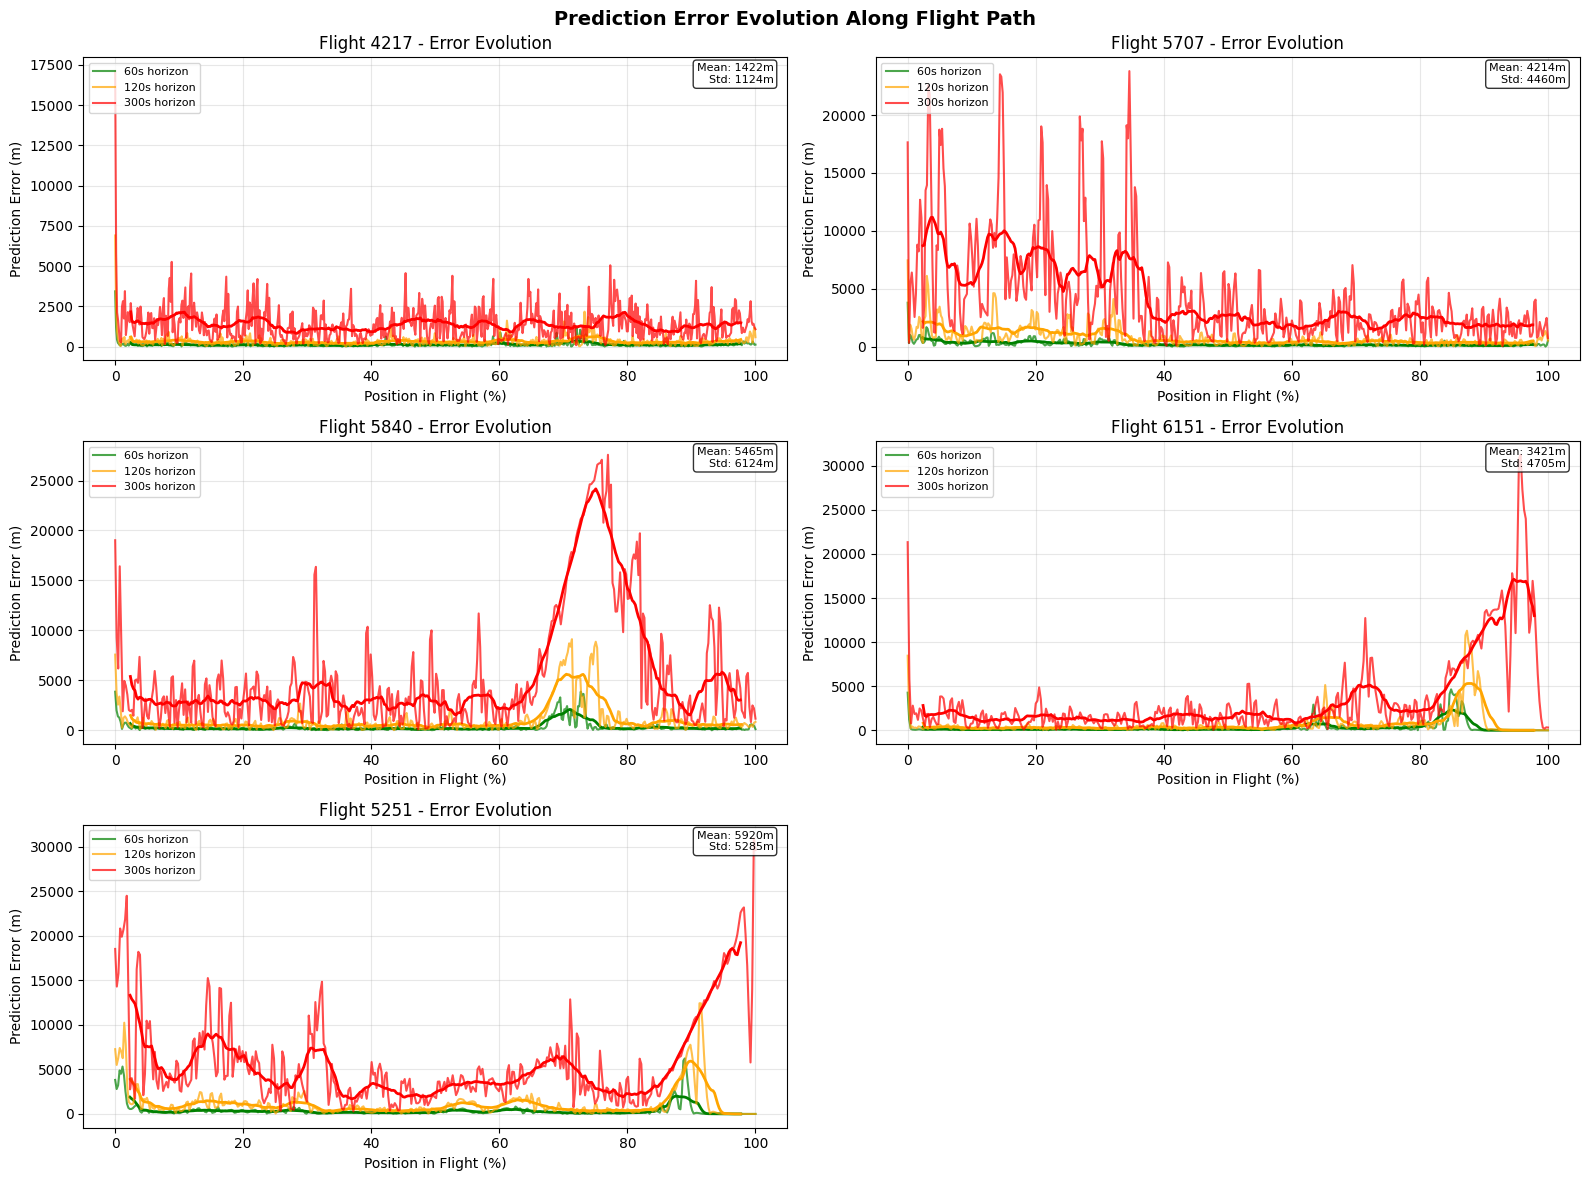

In [8]:
def plot_error_evolution():
    """Show how prediction error changes along the track"""
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    colors_h = {60: 'green', 120: 'orange', 300: 'red'}
    
    for idx, (flight_key, flight_data) in enumerate(top5_detailed.items()):
        ax = axes[idx]
        
        # Get error data from horizon results
        for h in [60, 120, 300]:
            if h in flight_data['horizon_results']:
                results = flight_data['horizon_results'][h]
                
                # X-axis: percentage through flight
                n_points = len(results)
                x_pct = np.linspace(0, 100, n_points)
                
                ax.plot(x_pct, results['err_m'], 
                       color=colors_h[h], alpha=0.7, linewidth=1.5,
                       label=f'{h}s horizon')
                
                # Add rolling mean
                window = max(5, n_points // 20)
                rolling_mean = results['err_m'].rolling(window=window, center=True).mean()
                ax.plot(x_pct, rolling_mean,
                       color=colors_h[h], linewidth=2)
        
        ax.set_xlabel('Position in Flight (%)')
        ax.set_ylabel('Prediction Error (m)')
        ax.set_title(f'Flight {flight_data["flight_id"]} - Error Evolution')
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        stats_text = f"Mean: {results['err_m'].mean():.0f}m\n"
        stats_text += f"Std: {results['err_m'].std():.0f}m"
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
               fontsize=8, va='top', ha='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Remove extra subplot
    if len(top5_detailed) < 6:
        fig.delaxes(axes[5])
    
    fig.suptitle('Prediction Error Evolution Along Flight Path',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

fig = plot_error_evolution()
plt.show()

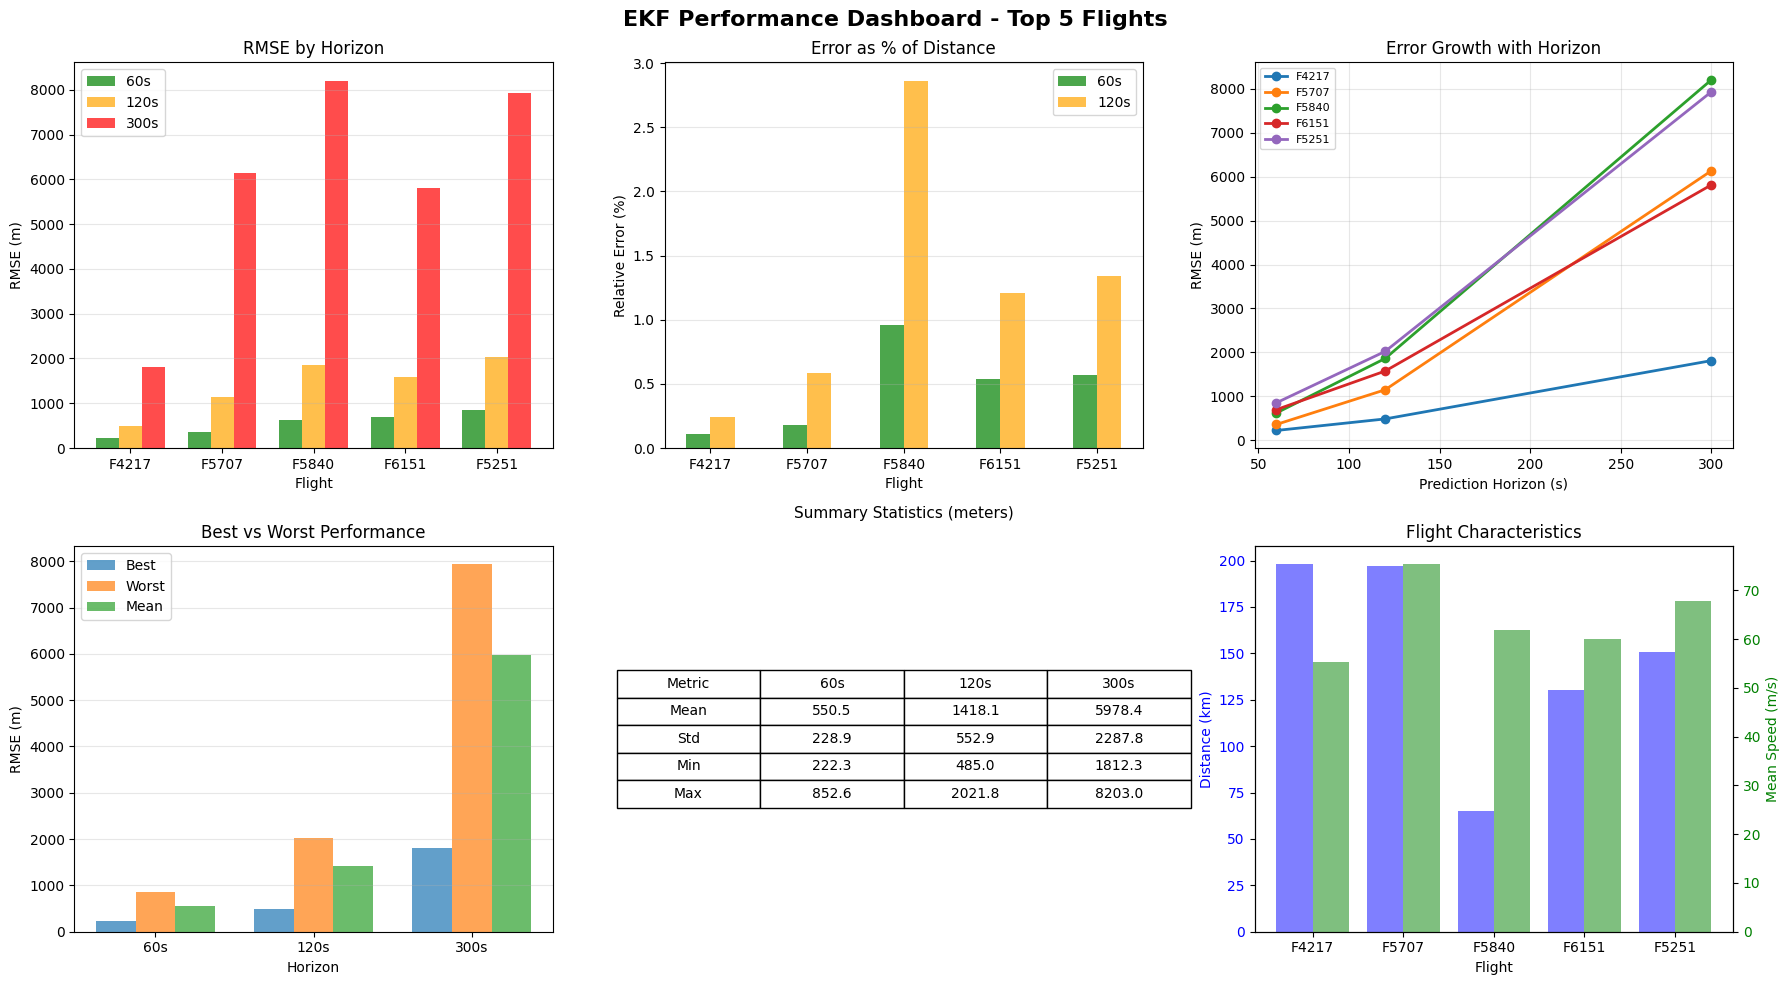

In [10]:
def create_performance_dashboard():
    """Create a comprehensive performance summary"""
    
    fig = plt.figure(figsize=(18, 10))
    
    # Collect all statistics
    flights = []
    rmse_60, rmse_120, rmse_300 = [], [], []
    distances = []
    
    for flight_key, flight_data in top5_detailed.items():
        flights.append(f"F{flight_data['flight_id']}")
        rmse_60.append(flight_data['rmse'][60])
        rmse_120.append(flight_data['rmse'][120])
        rmse_300.append(flight_data['rmse'][300])
        
        track = flight_data['resampled_track']
        dist = np.sqrt((track['E'].iloc[-1] - track['E'].iloc[0])**2 +
                      (track['N'].iloc[-1] - track['N'].iloc[0])**2) / 1000
        distances.append(dist)
    
    # 1. RMSE Comparison
    ax1 = plt.subplot(2, 3, 1)
    x = np.arange(len(flights))
    width = 0.25
    
    ax1.bar(x - width, rmse_60, width, label='60s', color='green', alpha=0.7)
    ax1.bar(x, rmse_120, width, label='120s', color='orange', alpha=0.7)
    ax1.bar(x + width, rmse_300, width, label='300s', color='red', alpha=0.7)
    
    ax1.set_xlabel('Flight')
    ax1.set_ylabel('RMSE (m)')
    ax1.set_title('RMSE by Horizon')
    ax1.set_xticks(x)
    ax1.set_xticklabels(flights)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Relative Error
    ax2 = plt.subplot(2, 3, 2)
    relative_60 = [r/d/1000 * 100 for r, d in zip(rmse_60, distances)]
    relative_120 = [r/d/1000 * 100 for r, d in zip(rmse_120, distances)]
    
    ax2.bar(x - width/2, relative_60, width, label='60s', color='green', alpha=0.7)
    ax2.bar(x + width/2, relative_120, width, label='120s', color='orange', alpha=0.7)
    
    ax2.set_xlabel('Flight')
    ax2.set_ylabel('Relative Error (%)')
    ax2.set_title('Error as % of Distance')
    ax2.set_xticks(x)
    ax2.set_xticklabels(flights)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Error Growth Rate
    ax3 = plt.subplot(2, 3, 3)
    horizons_plot = [60, 120, 300]
    
    for idx, flight in enumerate(flights):
        errors = [rmse_60[idx], rmse_120[idx], rmse_300[idx]]
        ax3.plot(horizons_plot, errors, marker='o', label=flight, linewidth=2)
    
    ax3.set_xlabel('Prediction Horizon (s)')
    ax3.set_ylabel('RMSE (m)')
    ax3.set_title('Error Growth with Horizon')
    ax3.legend(loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # 4. Best vs Worst Comparison
    ax4 = plt.subplot(2, 3, 4)
    
    best_idx = np.argmin(rmse_60)
    worst_idx = np.argmax(rmse_60)
    
    comparison_data = {
        'Best': [rmse_60[best_idx], rmse_120[best_idx], rmse_300[best_idx]],
        'Worst': [rmse_60[worst_idx], rmse_120[worst_idx], rmse_300[worst_idx]],
        'Mean': [np.mean(rmse_60), np.mean(rmse_120), np.mean(rmse_300)]
    }
    
    x_comp = np.arange(3)
    width_comp = 0.25
    
    for idx, (label, values) in enumerate(comparison_data.items()):
        ax4.bar(x_comp + idx*width_comp, values, width_comp, label=label, alpha=0.7)
    
    ax4.set_xlabel('Horizon')
    ax4.set_ylabel('RMSE (m)')
    ax4.set_title('Best vs Worst Performance')
    ax4.set_xticks(x_comp + width_comp)
    ax4.set_xticklabels(['60s', '120s', '300s'])
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Statistics Table
    ax5 = plt.subplot(2, 3, 5)
    ax5.axis('tight')
    ax5.axis('off')
    
    table_data = []
    table_data.append(['Metric', '60s', '120s', '300s'])
    table_data.append(['Mean', f'{np.mean(rmse_60):.1f}', 
                      f'{np.mean(rmse_120):.1f}', f'{np.mean(rmse_300):.1f}'])
    table_data.append(['Std', f'{np.std(rmse_60):.1f}',
                      f'{np.std(rmse_120):.1f}', f'{np.std(rmse_300):.1f}'])
    table_data.append(['Min', f'{np.min(rmse_60):.1f}',
                      f'{np.min(rmse_120):.1f}', f'{np.min(rmse_300):.1f}'])
    table_data.append(['Max', f'{np.max(rmse_60):.1f}',
                      f'{np.max(rmse_120):.1f}', f'{np.max(rmse_300):.1f}'])
    
    table = ax5.table(cellText=table_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax5.set_title('Summary Statistics (meters)', pad=20, fontsize=11)
    
    # 6. Flight Characteristics
    ax6 = plt.subplot(2, 3, 6)
    
    char_data = []
    for flight_key, flight_data in top5_detailed.items():
        track = flight_data['resampled_track']
        char_data.append({
            'flight': f"F{flight_data['flight_id']}",
            'distance': distances[len(char_data)],
            'mean_speed': track['speed'].mean(),
            'alt_range': (track['U'].max() - track['U'].min()) / 1000
        })
    
    char_df = pd.DataFrame(char_data)
    
    ax6_2 = ax6.twinx()
    
    x_char = np.arange(len(char_df))
    ax6.bar(x_char - 0.2, char_df['distance'], 0.4, 
           color='blue', alpha=0.5, label='Distance (km)')
    ax6_2.bar(x_char + 0.2, char_df['mean_speed'], 0.4,
            color='green', alpha=0.5, label='Speed (m/s)')
    
    ax6.set_xlabel('Flight')
    ax6.set_ylabel('Distance (km)', color='blue')
    ax6_2.set_ylabel('Mean Speed (m/s)', color='green')
    ax6.set_title('Flight Characteristics')
    ax6.set_xticks(x_char)
    ax6.set_xticklabels(char_df['flight'])
    
    ax6.tick_params(axis='y', labelcolor='blue')
    ax6_2.tick_params(axis='y', labelcolor='green')
    
    fig.suptitle('EKF Performance Dashboard - Top 5 Flights',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

fig = create_performance_dashboard()
plt.show()